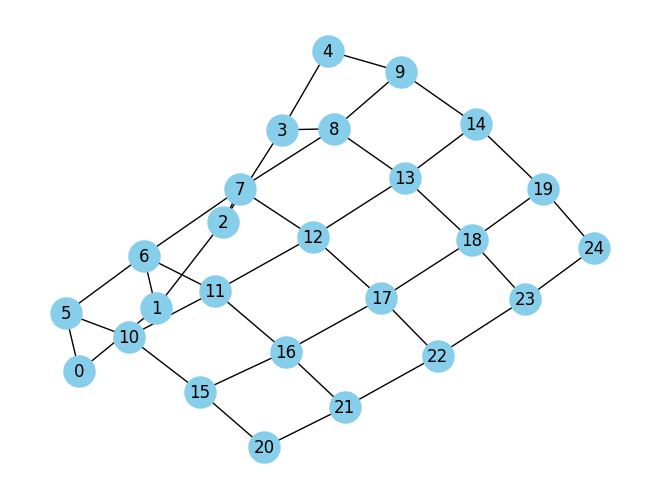

Epoch 10/100, Loss: 524.5095
Epoch 20/100, Loss: 379.7069
Epoch 30/100, Loss: 301.5809
Epoch 40/100, Loss: 222.7431
Epoch 50/100, Loss: 203.1846
Epoch 60/100, Loss: 198.7036
Epoch 70/100, Loss: 197.9271
Epoch 80/100, Loss: 196.8999
Epoch 90/100, Loss: 196.4535
Epoch 100/100, Loss: 196.3045

Predicted next positions for all nodes: [5, 6, 3, 8, 3, 10, 5, 8, 3, 8, 11, 6, 13, 12, 9, 16, 17, 22, 13, 14, 21, 22, 21, 18, 23]


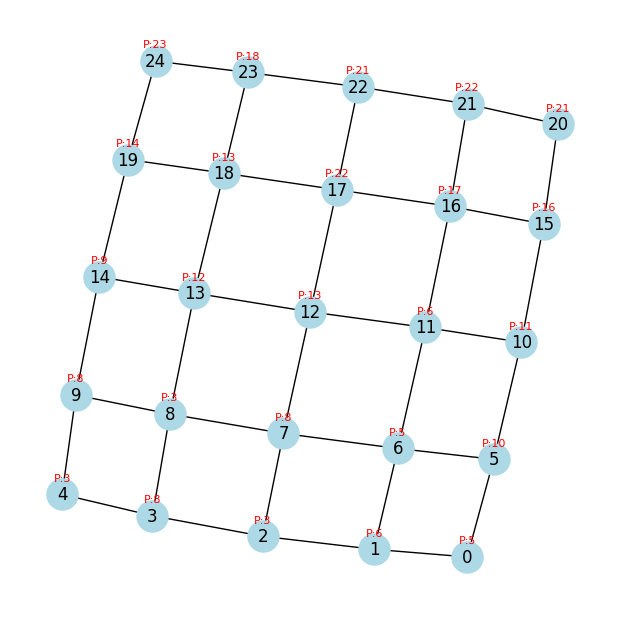

In [7]:
# ==========================
# Graph-Floor Robot Movement Predictor (Fully Corrected)
# ==========================

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import random

# --------------------------
# 1. Create Warehouse Graph
# --------------------------
def create_warehouse_graph(rows=5, cols=5):
    G = nx.grid_2d_graph(rows, cols)
    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)
    return G

warehouse_graph = create_warehouse_graph(5, 5)
nx.draw(warehouse_graph, with_labels=True, node_color='skyblue', node_size=500)
plt.show()

# --------------------------
# 2. Generate Synthetic Robot Paths
# --------------------------
num_nodes = warehouse_graph.number_of_nodes()
num_robots = 10
seq_len = 20

robot_paths = []
for _ in range(num_robots):
    path = [random.randint(0, num_nodes-1)]
    for _ in range(seq_len-1):
        neighbors = list(warehouse_graph.neighbors(path[-1]))
        next_node = random.choice(neighbors)
        path.append(next_node)
    robot_paths.append(path)

# --------------------------
# 3. Prepare Graph Data for PyG
# --------------------------
edge_index = torch.tensor(list(warehouse_graph.edges), dtype=torch.long).t().contiguous()
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

x = torch.eye(num_nodes, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

# --------------------------
# 4. Define GNN Model
# --------------------------
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.lin(x)
        return x

# --------------------------
# 5. Train the Model
# --------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(in_channels=num_nodes, hidden_channels=64, out_channels=num_nodes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

data = data.to(device)

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)  # [num_nodes, num_nodes]
    
    loss = 0
    for robot in range(num_robots):
        for t in range(seq_len-1):
            current_node = robot_paths[robot][t]
            target_node = robot_paths[robot][t+1]
            pred = out[current_node].unsqueeze(0)  # [1, num_nodes]
            target = torch.tensor([target_node], device=device)
            loss += criterion(pred, target)
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# --------------------------
# 6. Predict Next Moves
# --------------------------
model.eval()
predicted_next_positions = []
with torch.no_grad():
    out = model(data.x, data.edge_index)
    predicted_next_positions = torch.argmax(out, dim=1).tolist()

print("\nPredicted next positions for all nodes:", predicted_next_positions)

# --------------------------
# 7. Visualize Predictions
# --------------------------
plt.figure(figsize=(6,6))
pos = nx.spring_layout(warehouse_graph)
nx.draw(warehouse_graph, pos, with_labels=True, node_color='lightblue', node_size=500)
for node in range(num_nodes):
    plt.text(pos[node][0], pos[node][1]+0.05, f"P:{predicted_next_positions[node]}",
             horizontalalignment='center', fontsize=8, color='red')
plt.show()


## **Graph Neural Network for Predicting Robot Movements in a Warehouse**
---

### **1. Create Warehouse Graph**

```python
warehouse_graph = create_warehouse_graph(5, 5)
```

* Uses `networkx` to create a **5x5 grid graph** representing warehouse nodes (positions robots can occupy).
* Nodes are relabeled as integers `0` to `24`.
* Visualizes the warehouse layout.

---

### **2. Generate Synthetic Robot Paths**

```python
robot_paths = []
```

* Creates **10 synthetic robot paths**, each of length 20 (`seq_len = 20`).
* Each robot starts at a random node and moves randomly to one of the neighboring nodes at each step.
* This simulates robot trajectories in the warehouse.

---

### **3. Prepare Graph Data for PyTorch Geometric (PyG)**

```python
edge_index = torch.tensor(list(warehouse_graph.edges), dtype=torch.long).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
```

* Converts the `networkx` graph into a **PyG `Data` object**.
* `edge_index`: adjacency info for the GNN.
* `x`: identity matrix as **node features** (one-hot for each node).

---

### **4. Define GNN Model**

```python
class GNN(torch.nn.Module):
    ...
```

* Defines a simple **Graph Convolutional Network (GCN)** with:

  1. Two `GCNConv` layers (hidden size 64)
  2. ReLU activation
  3. Final linear layer outputs predictions for all nodes

* Goal: predict **next node for each robot** based on the current graph structure.

---

### **5. Train the Model**

```python
for epoch in range(epochs):
    ...
```

* Trains the GNN to **predict the next node in each robot path**.
* For each robot and each time step:

  * `current_node` is the current robot position.
  * `target_node` is the next node in its path.
  * Cross-entropy loss is used to train the GNN to predict the correct next node.
* Uses **Adam optimizer**, 100 epochs, and prints loss every 10 epochs.

---

### **6. Predict Next Moves**

```python
predicted_next_positions = torch.argmax(out, dim=1).tolist()
```

* After training, the model predicts **next positions for all nodes** in the warehouse.
* `argmax` selects the most likely next node for each current node.

---

### **7. Visualize Predictions**

```python
nx.draw(...)
plt.text(...)
```

* Draws the warehouse graph.
* Labels each node with its **predicted next node**, showing where the GNN expects a robot to move next.

---

### ✅ **In short:**

1. Simulates robots moving randomly in a warehouse grid.
2. Trains a **Graph Neural Network** to learn movement patterns.
3. Predicts the next position for each node.
4. Visualizes the predicted moves on the warehouse graph.

---


## **Line by line Explanation** 
---

## **1. Import Libraries**

```python
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import random
```

**Explanation:**

* `torch`: Core PyTorch library for tensors and deep learning.
* `torch.nn.functional as F`: Provides activation functions like `relu`.
* `GCNConv` from `torch_geometric.nn`: Graph Convolutional layer for GNNs.
* `Data` from `torch_geometric.data`: Stores graph data for PyTorch Geometric.
* `networkx`: For creating and handling graphs.
* `matplotlib.pyplot`: For visualization (plotting the graph).
* `random`: To generate random robot paths.

---

## **2. Create Warehouse Graph**

```python
def create_warehouse_graph(rows=5, cols=5):
    G = nx.grid_2d_graph(rows, cols)
    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)
    return G
```

**Explanation:**

* Creates a **2D grid graph** representing the warehouse layout.
* `grid_2d_graph(rows, cols)`: Nodes arranged in rows × columns grid.
* `mapping`: Converts tuple nodes like `(0,0)` into integers `0,1,...`.
* `relabel_nodes`: Replaces tuple labels with integers for easier indexing.

```python
warehouse_graph = create_warehouse_graph(5, 5)
nx.draw(warehouse_graph, with_labels=True, node_color='skyblue', node_size=500)
plt.show()
```

* Draws the warehouse graph with nodes labeled `0–24` and visualized in **sky blue**.

---

## **3. Generate Synthetic Robot Paths**

```python
num_nodes = warehouse_graph.number_of_nodes()
num_robots = 10
seq_len = 20
```

* `num_nodes`: Total nodes in the graph (25 in 5×5).
* `num_robots`: Simulate 10 robots.
* `seq_len`: Each robot path length is 20 steps.

```python
robot_paths = []
for _ in range(num_robots):
    path = [random.randint(0, num_nodes-1)]
    for _ in range(seq_len-1):
        neighbors = list(warehouse_graph.neighbors(path[-1]))
        next_node = random.choice(neighbors)
        path.append(next_node)
    robot_paths.append(path)
```

* For each robot:

  * Start at a **random node**.
  * For each step, move randomly to **one of the neighbors**.
  * Appends the path to `robot_paths`.

---

## **4. Prepare Graph Data for PyTorch Geometric**

```python
edge_index = torch.tensor(list(warehouse_graph.edges), dtype=torch.long).t().contiguous()
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
```

* Converts NetworkX edges to **PyTorch tensor**.
* `.t().contiguous()`: Transposes to shape `[2, num_edges]`.
* `torch.cat([...], dim=1)`: Adds **reverse edges** to make the graph undirected.

```python
x = torch.eye(num_nodes, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
```

* `x`: Identity matrix as **node features** (one-hot for each node).
* `Data(...)`: Wraps graph data (features + edges) for PyG.

---

## **5. Define GNN Model**

```python
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.lin(x)
        return x
```

* **GNN Structure:**

  1. `GCNConv`: First graph convolution layer.
  2. `ReLU`: Activation.
  3. `GCNConv`: Second graph convolution layer.
  4. `ReLU`: Activation.
  5. `Linear`: Maps hidden features to **node predictions**.
* Input: `x` (node features) + `edge_index` (graph structure).
* Output: logits for predicting **next node** for each node.

---

## **6. Train the Model**

```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(in_channels=num_nodes, hidden_channels=64, out_channels=num_nodes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
data = data.to(device)
```

* Moves model and data to **GPU if available**.
* `in_channels=num_nodes` → one-hot input per node.
* `out_channels=num_nodes` → predict next node among all nodes.
* Optimizer: Adam, Learning rate 0.01.
* Loss: Cross-entropy for classification (predicting correct next node).

```python
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)  # [num_nodes, num_nodes]
    
    loss = 0
    for robot in range(num_robots):
        for t in range(seq_len-1):
            current_node = robot_paths[robot][t]
            target_node = robot_paths[robot][t+1]
            pred = out[current_node].unsqueeze(0)  # [1, num_nodes]
            target = torch.tensor([target_node], device=device)
            loss += criterion(pred, target)
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
```

* Training loop:

  1. Forward pass: Predict next nodes.
  2. For each robot at each time step, compute **cross-entropy loss** between predicted and actual next node.
  3. Backpropagate loss and **update weights**.
  4. Print loss every 10 epochs.

---

## **7. Predict Next Moves**

```python
model.eval()
predicted_next_positions = []
with torch.no_grad():
    out = model(data.x, data.edge_index)
    predicted_next_positions = torch.argmax(out, dim=1).tolist()
```

* Switch model to **evaluation mode**.
* `torch.no_grad()`: Disable gradients.
* Predict next node for each node using **argmax** on logits.

---

## **8. Visualize Predictions**

```python
plt.figure(figsize=(6,6))
pos = nx.spring_layout(warehouse_graph)
nx.draw(warehouse_graph, pos, with_labels=True, node_color='lightblue', node_size=500)
for node in range(num_nodes):
    plt.text(pos[node][0], pos[node][1]+0.05, f"P:{predicted_next_positions[node]}",
             horizontalalignment='center', fontsize=8, color='red')
plt.show()
```

* Draws warehouse graph using `spring_layout` (nodes spaced nicely).
* Labels each node with **predicted next position** `P:<node>` in red.
* Visualizes how the GNN predicts robot movements.

---

### **Summary of Workflow**

1. Create a warehouse as a **graph**.
2. Generate **synthetic robot paths** randomly.
3. Prepare **PyG graph data**.
4. Define **Graph Neural Network**.
5. Train GNN to predict **next node** for robots.
6. Predict next positions for all nodes.
7. Visualize predictions on the warehouse graph.

---



## **100 Interview Questions & Answers on Graph Neural Networks for Robot Movement Prediction (Python, PyTorch, PyTorch Geometric, NetworkX)**
---

## **EASY QUESTIONS (30)**

1. **Q:** What is NetworkX used for in this code?
   **A:** NetworkX is used to create and visualize the warehouse as a graph, specifically a 5x5 grid graph.

2. **Q:** What does `torch.eye(num_nodes)` do?
   **A:** Creates an identity matrix of size `num_nodes × num_nodes`, used as one-hot node features.

3. **Q:** How many robots are simulated in this code?
   **A:** 10 robots.

4. **Q:** What is `seq_len`?
   **A:** The length of each robot's path, set to 20 steps.

5. **Q:** What does `nx.grid_2d_graph(rows, cols)` create?
   **A:** A 2D grid graph with `rows × cols` nodes, connected like a grid.

6. **Q:** What is the purpose of `edge_index`?
   **A:** Stores graph connectivity in a format PyTorch Geometric expects.

7. **Q:** Why do we concatenate `edge_index` with its flipped version?
   **A:** To make the graph undirected, ensuring edges work in both directions.

8. **Q:** What does `GCNConv` do?
   **A:** Performs graph convolution, aggregating information from neighboring nodes.

9. **Q:** Why use `F.relu` after convolution layers?
   **A:** Applies non-linearity to allow the network to learn complex patterns.

10. **Q:** What does the final `Linear` layer output?
    **A:** Logits for predicting the next node for each current node.

11. **Q:** What loss function is used?
    **A:** `CrossEntropyLoss` for node classification.

12. **Q:** Which optimizer is used?
    **A:** Adam optimizer with learning rate 0.01.

13. **Q:** What does `model.train()` do?
    **A:** Sets the model to training mode, enabling gradient updates.

14. **Q:** What does `model.eval()` do?
    **A:** Switches the model to evaluation mode, disabling dropout and gradients.

15. **Q:** Why use `torch.no_grad()` during prediction?
    **A:** To save memory and computation by disabling gradient calculations.

16. **Q:** What does `torch.argmax(out, dim=1)` do?
    **A:** Selects the node with the highest predicted probability as the next move.

17. **Q:** What is the purpose of `robot_paths`?
    **A:** Stores synthetic paths for each robot for training the GNN.

18. **Q:** Why do we generate random robot paths?
    **A:** To create training data simulating robot movements in the warehouse.

19. **Q:** How is the graph visualized?
    **A:** Using `networkx.draw()` with node labels and colors.

20. **Q:** What does `plt.text()` do in visualization?
    **A:** Adds predicted next node labels above each node.

21. **Q:** What device is used for training?
    **A:** GPU if available, otherwise CPU.

22. **Q:** How many epochs are used for training?
    **A:** 100 epochs.

23. **Q:** What does `optimizer.zero_grad()` do?
    **A:** Clears previous gradients before backpropagation.

24. **Q:** Why do we use `loss.backward()`?
    **A:** Computes gradients of the loss with respect to model parameters.

25. **Q:** What is `hidden_channels=64`?
    **A:** The number of neurons in the hidden GCN layers.

26. **Q:** How are neighbors of a node accessed?
    **A:** Using `warehouse_graph.neighbors(node)`.

27. **Q:** Why do we start each robot path at a random node?
    **A:** To simulate diverse starting positions in the warehouse.

28. **Q:** What type of learning task is this model performing?
    **A:** Node classification (predicting the next node).

29. **Q:** What library provides `Data` for graph representation?
    **A:** PyTorch Geometric.

30. **Q:** How are edges represented in PyTorch Geometric?
    **A:** As a tensor of shape `[2, num_edges]`, called `edge_index`.

---

## **MODERATE QUESTIONS (40)**

31. **Q:** Why is the input dimension equal to `num_nodes`?
    **A:** Each node is represented as a one-hot vector of length `num_nodes`.

32. **Q:** What would happen if you don’t flip `edge_index`?
    **A:** The GNN would treat the graph as directed; some neighbors might be ignored.

33. **Q:** How does GCNConv aggregate information?
    **A:** It sums or averages features from neighboring nodes and applies a linear transformation.

34. **Q:** Can this model handle variable-length paths?
    **A:** Yes, as long as the node features and edge index are consistent.

35. **Q:** What is the shape of `out` from the GNN?
    **A:** `[num_nodes, num_nodes]` — each row predicts next node probabilities for a current node.

36. **Q:** How is the loss computed per robot?
    **A:** For each time step, compute cross-entropy loss between predicted and actual next node.

37. **Q:** Why is `pred` unsqueezed?
    **A:** To match the shape `[1, num_nodes]` required by `CrossEntropyLoss`.

38. **Q:** Can this GNN be used for real robots?
    **A:** Yes, with proper path data; currently, it trains on synthetic paths.

39. **Q:** What activation function is used in hidden layers?
    **A:** ReLU (Rectified Linear Unit).

40. **Q:** Why two GCNConv layers instead of one?
    **A:** Two layers allow the model to aggregate information from 2-hop neighbors.

41. **Q:** What is the purpose of the linear layer after GCNs?
    **A:** Maps hidden features to logits for each possible next node.

42. **Q:** Why use CrossEntropyLoss for next-node prediction?
    **A:** Because predicting the next node is a **multi-class classification** problem.

43. **Q:** Could we use MSE loss here?
    **A:** Not ideal, as next-node prediction is categorical, not regression.

44. **Q:** How are synthetic paths generated?
    **A:** Randomly, by moving to a random neighbor at each step.

45. **Q:** How to modify the code for a larger warehouse?
    **A:** Change `rows` and `cols` in `create_warehouse_graph()`.

46. **Q:** Why use one-hot encoding for nodes?
    **A:** It uniquely identifies each node, as no other node features exist.

47. **Q:** How to increase model capacity?
    **A:** Increase `hidden_channels` or add more GCNConv layers.

48. **Q:** What is the role of `device`?
    **A:** Ensures tensors and model are on GPU/CPU for computation.

49. **Q:** Why is the predicted output called `predicted_next_positions`?
    **A:** Each index corresponds to a node and stores the predicted next node.

50. **Q:** What is `torch.cat([edge_index, edge_index.flip(0)], dim=1)` doing?
    **A:** Ensures each edge is bidirectional.

51. **Q:** How is training supervised?
    **A:** The model is trained using known paths as labels for each node at each step.

52. **Q:** Why visualize predictions?
    **A:** To interpret model behavior and validate predictions visually.

53. **Q:** How to interpret `out[current_node]`?
    **A:** It’s the predicted logits for all possible next nodes from `current_node`.

54. **Q:** How would you modify the code for weighted edges?
    **A:** Pass `edge_weight` to `GCNConv`.

55. **Q:** Can this model generalize to unseen paths?
    **A:** Partially; depends on graph structure and similarity to training paths.

56. **Q:** What happens if two robots start at the same node?
    **A:** Each path is processed independently; training still works.

57. **Q:** Why are paths stored as lists of node indices?
    **A:** Easy indexing and feeding into PyTorch tensors.

58. **Q:** How to handle dynamic robot numbers?
    **A:** Adjust `num_robots` and regenerate paths accordingly.

59. **Q:** How does `nx.draw()` layout nodes?
    **A:** Uses default spring layout or specified `pos` for visualization.

60. **Q:** How to increase training speed?
    **A:** Reduce number of robots, nodes, epochs, or use GPU.

61. **Q:** Why use `random.choice(neighbors)`?
    **A:** To simulate random movement for training data.

62. **Q:** Could we use LSTM instead of GNN?
    **A:** LSTM could model sequences but wouldn’t capture graph structure.

63. **Q:** How to save the trained model?
    **A:** Use `torch.save(model.state_dict(), 'model.pth')`.

64. **Q:** How to load the model later?
    **A:** `model.load_state_dict(torch.load('model.pth'))`.

65. **Q:** Why not use features other than one-hot?
    **A:** No other features exist; one-hot suffices to identify nodes.

66. **Q:** How is `loss` aggregated?
    **A:** Summed over all robots and time steps.

67. **Q:** What does `.tolist()` do?
    **A:** Converts PyTorch tensor to a Python list for easy visualization.

68. **Q:** What is the shape of `x`?
    **A:** `[num_nodes, num_nodes]` — one-hot features per node.

69. **Q:** Can we use different GNN layers?
    **A:** Yes, e.g., `GraphSAGEConv`, `GATConv`.

70. **Q:** Why visualize with `spring_layout` instead of grid layout?
    **A:** Spring layout spreads nodes for better visibility; grid layout may overlap labels.

---

## **HARD QUESTIONS (30)**

71. **Q:** Explain why GCNConv can capture neighborhood information.
    **A:** Each GCNConv aggregates neighbor node features, so node embeddings contain local graph context.

72. **Q:** How does the network differentiate between nodes without features?
    **A:** One-hot encoding uniquely identifies nodes.

73. **Q:** Why not use adjacency matrix directly as input?
    **A:** GCNConv uses adjacency internally; input features still required.

74. **Q:** Could this GNN overfit? How?
    **A:** Yes, on synthetic paths or small graphs, it may memorize paths instead of generalizing.

75. **Q:** How would you modify the loss for batch training?
    **A:** Use mini-batches of nodes or robot paths with appropriate masking.

76. **Q:** Explain the time complexity of one GCNConv layer.
    **A:** O(E × F\_in × F\_out), where E = edges, F\_in = input features, F\_out = output features.

77. **Q:** Can we predict multiple steps ahead?
    **A:** Yes, recursively feed predicted positions as input for next steps.

78. **Q:** How would you handle directed warehouse paths?
    **A:** Don’t flip edge\_index; preserve directionality in edges.

79. **Q:** How is this different from sequence modeling with RNN?
    **A:** GNN captures graph topology; RNN captures only temporal sequences.

80. **Q:** Can this model detect congestion?
    **A:** Not directly, but aggregating predicted positions can indicate congestion.

81. **Q:** How to modify node features to include robot type?
    **A:** Concatenate one-hot encoding for robot type to node features.

82. **Q:** Could attention-based GNN improve predictions?
    **A:** Yes, GAT layers can weigh neighbor contributions differently.

83. **Q:** How to interpret learned embeddings in conv layers?
    **A:** Each node embedding encodes neighborhood information; visualization can reveal clusters.

84. **Q:** Why use ReLU instead of sigmoid/tanh?
    **A:** ReLU avoids vanishing gradients and works well in deep GNNs.

85. **Q:** How does PyG handle sparse adjacency internally?
    **A:** Uses sparse matrix multiplication for efficient aggregation.

86. **Q:** Can this GNN generalize to a larger warehouse?
    **A:** Partially; one-hot input size would need adjustment.

87. **Q:** How would you include edge weights (distances)?
    **A:** Pass `edge_weight` tensor to `GCNConv`.

88. **Q:** Why not use a fully connected network for next-node prediction?
    **A:** FCN ignores graph topology; GNN leverages neighbor structure.

89. **Q:** How can you evaluate prediction accuracy?
    **A:** Compare predicted next nodes with actual next nodes in test paths.

90. **Q:** Explain why multiple GCN layers improve receptive field.
    **A:** Each layer aggregates one-hop neighbors; stacking layers increases neighborhood coverage.

91. **Q:** Could node normalization improve training?
    **A:** Yes, normalizing input features or adjacency can stabilize learning.

92. **Q:** How does GCNConv handle isolated nodes?
    **A:** Typically adds self-loops to ensure isolated nodes have embeddings.

93. **Q:** How to visualize node embeddings learned by GNN?
    **A:** Use t-SNE or PCA on hidden layer outputs.

94. **Q:** How would you predict a robot’s entire future path?
    **A:** Recursively apply the model using predicted nodes as next inputs.

95. **Q:** How to modify the model for multiple robots simultaneously?
    **A:** Include robot ID features or train separate models per robot type.

96. **Q:** Could this approach scale to hundreds of robots?
    **A:** Yes, but memory and computation increase; batching may be required.

97. **Q:** How to integrate real-time robot sensor data?
    **A:** Update node features dynamically and feed them to GNN.

98. **Q:** How can edge pruning affect predictions?
    **A:** Reduces possible movements; may improve or degrade accuracy depending on connectivity.

99. **Q:** Why is the linear layer applied after convolutions?
    **A:** To map learned embeddings to the desired output dimension (next node logits).

100. **Q:** How to extend this to 3D warehouse graphs?
     **A:** Use a 3D grid graph, adjust node indexing, and keep same GNN structure.

---
